# Double-Sided Crystal Ball Signal Fit
This notebook fits the double-sided crystal ball function to the Monte-Carlo simulated signal events. Only pure category 10 and category 50 events are used as these are the 'best' quality signal events. The fit routines will be a least-squares (technically a chi-square as we will include errors) and a maximum likelihood fit.

In [1]:
# Gather the necessary libraries needed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../')
from utilities import Data, Consts, Model

In [2]:
s = Data(*Consts().get_simulated_tuple())
# Create a data object from the unpacked constant filenames

df = s.fetch_features(['Lb_M', 'Lb_BKGCAT'])
# Get the invariant mass and background category features for all simulated events

df['cat'] = np.where(df['Lb_BKGCAT'].isin([10, 50]), 1, 0)
# Create a category column which is based on the BKGCAT value 1 = signal, 0 = non-signal

df.drop('Lb_BKGCAT', axis=1, inplace=True)
# Now remove the BKGCAT column, it is redundant now

g = df.groupby('cat')
# Group the events by the category (1 or 0)

## Plotting Initial Mass Distribution
Now we will plot the initial mass distribution for the events we care about, that is signal category 1 events. This is just so we know what we are working with. Errors are computed assuming Poisson statistics that is $\sigma\propto\sqrt{N}$.

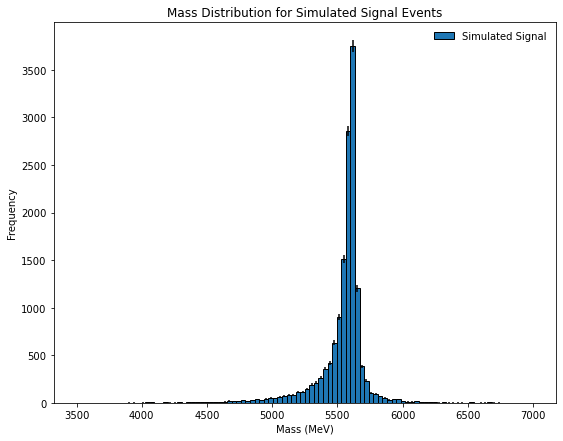

In [3]:
low_mass_limit, high_mass_limit = 3500, 7000
no_bins = 100
bins = np.linspace(low_mass_limit, high_mass_limit, no_bins+1)
# Create an array of bin edges

bin_centres = [np.mean(bins[i:i+2]) for i in range(len(bins)-1)]
bin_width = bins[1]- bins[0]

data = g.get_group(1)[g.get_group(1)['Lb_M'].between(low_mass_limit, high_mass_limit)]

f, _ = np.histogram(g.get_group(1)['Lb_M'], bins=bins)
err = np.sqrt(f)
# The error is the square root of the frequency

d = np.array([bin_centres, f, err]).T
# Make an array of the bin centroid the frequency and the associated error

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.bar(d[:,0], d[:,1], width=bin_width, yerr=d[:,2], label='Simulated Signal', edgecolor='k', color='#1f77b4')
ax.set_ylabel('Frequency')
ax.set_xlabel('Mass (MeV)')
plt.title('Mass Distribution for Simulated Signal Events')
plt.legend(frameon=False)
plt.show()

## Preparation for Fitting the DSCB
Now we have plotted these data we will now attempt to fit them using a statistically sound routine(s). Before fitting we need to remove all the bins with zero frequency and hence zero error to prevent issues when doing math.

Secondly the DSCB is a probabilty distribution as such we should normalise the values associated with the previously computed histogram.

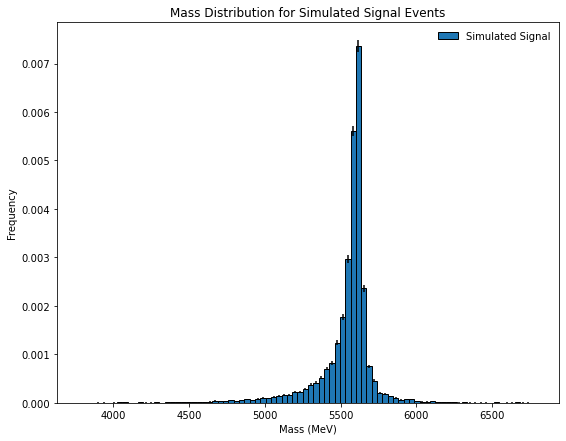

In [4]:
f_norm, _ = np.histogram(g.get_group(1)['Lb_M'], bins=bins, density=True)
err_norm = err / (max(f)/max(f_norm))
# The error is the square root of the frequency

d_norm = np.array([bin_centres, f_norm, err_norm]).T
# Make an array of the bin centroid the frequency and the associated error

d_norm = d_norm[d_norm[:,1]!=0,:]
# Remove all the bins with no signal candidates recorded

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.bar(d_norm[:,0], d_norm[:,1], width=bin_width, yerr=d_norm[:,2], label='Simulated Signal', edgecolor='k', color='#1f77b4')
ax.set_ylabel('Frequency')
ax.set_xlabel('Mass (MeV)')
plt.title('Mass Distribution for Simulated Signal Events')
plt.legend(frameon=False)
plt.show()

## Defining and Fitting
Now we have scaled our data and errors down appropriately with some, unseen but calculated, scale factor. We now need to define the DSCB function and try to fit it!

In [5]:
my_func = Model.dscb

In [6]:
from scipy.optimize import curve_fit

popt, pcov = curve_fit(my_func, d_norm[:,0], d_norm[:,1], p0=[5600, 40, 0.7, 1.43, 5.01, 5.13], sigma=d_norm[:,2])

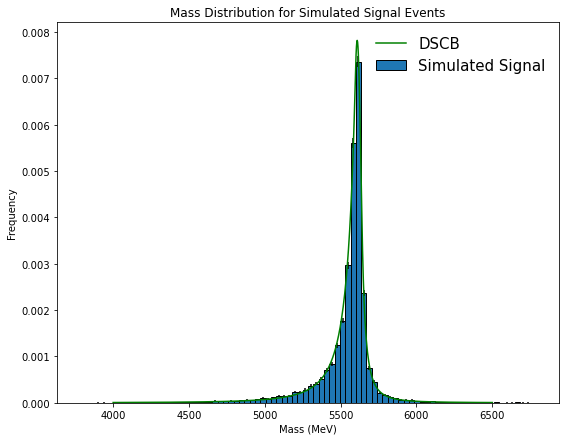

In [8]:
masses = np.linspace(4000, 6500, 1000)

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.bar(d_norm[:,0], d_norm[:,1], width=bin_width, yerr=d_norm[:,2], label='Simulated Signal', edgecolor='k', color='#1f77b4')
ax.plot(masses, my_func(masses, *popt), label='DSCB', color='green')
ax.set_ylabel('Frequency')
ax.set_xlabel('Mass (MeV)')
plt.title('Mass Distribution for Simulated Signal Events')
plt.legend(frameon=False, prop={'size': 15})
plt.savefig('/home/user211/project/images/SignalDSCBOptimised.png', dpi=800)
plt.show()

Great news! We have a fit using a least-squares routines with errors on the parameters. Now let us calculate a chi-square per d.o.f on this fit.

In [9]:
def chi_square_dof(model, params, data, significane=0.05):
    """
    Calculate the chi-squared per degree of freedom for some data and a model
    
    Returns
    -------
    chi_square_dof : float
        The value of the chi squared per degrees of freedom statistic for
        the distribution under test. 
    
    accept_model : bool
        Whether to accept (true) or reject (false) the model based on the
        chi-squared statistic calculated and the significance level. By
        default this is a 5% two-tailed test. 
    """
    from scipy.stats import chi2
    df = len(data[:,0]) - len(params)
    test_value = chi2.ppf(1-significane, df)/df
    chi_square = np.sum(((data[:,1]-model(data[:,0], *params))/data[:,2])**2) 
    chi_squared_dof = chi_square/df
    return chi_squared_dof, chi_squared_dof < test_value

chi_dof = chi_square_dof(my_func, popt, d_norm)[0]
chi_dof

2.2875409312729964

In [10]:
e = np.sqrt(np.diag(pcov))
for j, i in enumerate(popt):
    print(f'Value: {i:.3f} +/- {e[j]:.3f}')

Value: 5609.096 +/- 1.210
Value: 26.610 +/- 1.669
Value: 0.502 +/- 0.037
Value: 1.228 +/- 0.091
Value: 2.872 +/- 0.119
Value: 2.199 +/- 0.145


In [11]:
f = open('DSCB_Fit_Parameters.txt', 'w')
for j, i in enumerate(popt):
    writeable = f'{i} +/- {e[j]}\n'
    f.write(writeable)
f.close()

## Maximum Likelihood Estimation
Now we perform a parameter estimation using a maximum-likelihood estimation technique. This technique is far more common in the physical sciences.

In [67]:
from scipy.stats import poisson
import sys
from scipy.stats import norm
from scipy.optimize import minimize
sys.path.append('../')
import utilities as ut

In [73]:
freqs, data = d_norm[:,0], d_norm[:,1]

def log_likelihood_fast(mu, s, alow, ahigh, nlow, nhigh, f=freqs, d=data):
    m = ut.Model.dscb(f, mu, s, alow, ahigh, nlow, nhigh)
    return np.sum(poisson(m).logpmf(d))

def log_prior(mu, s, alow, ahigh, nlow, nhigh, mux=5700, mum=5500, sx=30, sm=20, alowx=1., alowm=0.2, ahighx=2, ahighm=1, nlowx=3, nlowm=2, nhighx=3, nhighm=2):
    """
    P(mu, sigma, alow, ahigh, nlow, nhigh)
    """
    mu_logp = -np.log(mu) - np.log(np.log(mux/mum))
    s_logp = -np.log(s) - np.log(np.log(sx/sm))
    alow_lp = -np.log(alow) - np.log(np.log(alowx/alowm))
    ahigh_lp = -np.log(ahigh) - np.log(np.log(ahighx/ahighm))
    nlow_lp = -np.log(nlow) - np.log(np.log(nlowx/nlowm))
    nhigh_lp = -np.log(nhigh) - np.log(np.log(nhighx/nhighm))
    return mu_logp + s_logp + alow_lp + ahigh_lp + nlow_lp + nhigh_lp

def log_posterior(mu, s, alow, ahigh, nlow, nhigh, f=freqs, d=data):
    return (log_likelihood_fast(mu, s, alow, ahigh, nlow, nhigh, f=f, d=d)+log_prior(mu, s, alow, ahigh, nlow, nhigh))

In [74]:
from scipy.optimize import minimize

x0 = (5600, 27, 0.5, 1.2, 2.9, 2.2)
sol = minimize(lambda x: -log_posterior(x[0], x[1], x[2], x[3], x[4], x[5]), x0)
sol

      fun: inf
 hess_inv: array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])
      jac: array([nan, nan, nan, nan, nan, nan])
  message: 'NaN result encountered.'
     nfev: 7
      nit: 0
     njev: 1
   status: 3
  success: False
        x: array([5.6e+03, 2.7e+01, 5.0e-01, 1.2e+00, 2.9e+00, 2.2e+00])

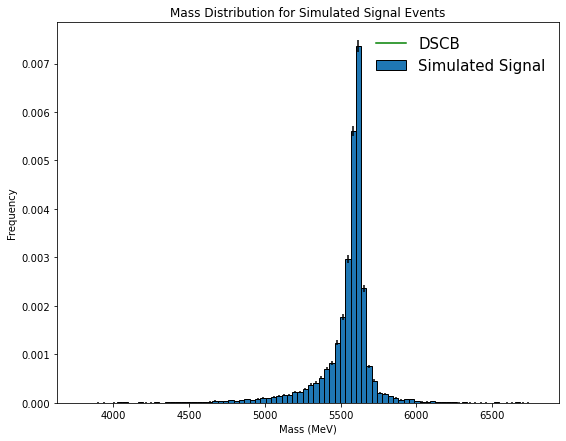

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.bar(d_norm[:,0], d_norm[:,1], width=bin_width, yerr=d_norm[:,2], label='Simulated Signal', edgecolor='k', color='#1f77b4')
ax.plot(masses, my_func(masses, *sol['x']), label='DSCB', color='green')
ax.set_ylabel('Frequency')
ax.set_xlabel('Mass (MeV)')
plt.title('Mass Distribution for Simulated Signal Events')
plt.legend(frameon=False, prop={'size': 15})
plt.show()